In [ ]:
!pip install d2l==1.0.0-beta0

Chúng ta đã biết về overfitting, nên chúng ta có thể giới thiệu về kỹ thuật *regularization*. Note rằng, chúng ta có thể giảm thiểu việc bị overfiting bằng cách thu thập thêm dữ liệu. Tuy nhiên, điều đó tốn kém, mất time hoặc nằm ngoài tầm kiểm soát. Hiện tại, ta giả định rằng đã sở hữu nhiều dữ liệu chất lượng cao nhất.

Ta có thế giới hạn khả năng của model bằng cách điều chỉnh căn bậc của đa thức phù hợp. Giới hạn số lượng features là một kỹ thuật phổ biến để giảm thiểu trình trạng overfiting.

Bám sát vào ví dụ về hồi quy đa thức, hay xem điều gì có thể xảy ra với đầu vào nhiều chiều. Các phần mở rộng tự nhiên của đa thức cho dữ liệu đa biến được gọi là đơn thức , đơn giản là tích lũy thừa của các biến. Bậc của một đơn thức là tổng các lũy thừa. Ví dụ,${x_1}^2x_2$ và $x_3{x_5}^2$ 
 đều là đơn thức bậc 3.

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#3.7.1. Norm và Weight Decay

Thay vì thao tác trực tiếp với số lượng tham số, Weight Decay hoạt động bằng cách hạn chế các giá trị mà tham số có thể nhận. Chuẩn $\ell_2$ thường được gọi ngoài vòng học sâu sau khi được tối ưu hóa bằng Minibatch SGĐ, Weight Decay có thể là kỹ thuật được sử dụng rộng rãi nhất để chuẩn hóa các mô hình học máy tham số. Kỹ thuật này được thúc đẩy bởi trực giác cơ bản rằng là trong số tất cả các hàm $f$, $f=0$ (gán 0 cho tất cả các input) theo một nghĩa nào đó là đơn giản nhất và ta có thể đo độ phức tạp của hàm số bằng khoảng cách tham số của nó từ 0. 

Một cách giải thích đơn giản có thể là đo độ phức tạp của hàm tuyến tính $f(x) = w^Tx$ bởi một số tiêu chuẩn của vectơ trọng số của nó, ví dụ, $||w||^2$. Nhớ lại rằng chúng ta đã giới thiệu $\ell_2$
 và $\ell_1$
, đó là những trường hợp đặc biệt của tổng quát hơn
của $\ell_p$ tại Mục 2.3.11 . Phương pháp phổ biến nhất để đảm bảo véc tơ trọng số nhỏ là thêm chuẩn của nó như một số hạng phạt cho bài toán giảm thiểu tổn thất. Do đó, chúng tôi thay thế mục tiêu ban đầu của mình, giảm thiểu tổn thất dự đoán trên nhãn đào tạo , bằng mục tiêu mới, giảm thiểu tổng tổn thất dự đoán và thời hạn phạt . Bây giờ, nếu vectơ trọng số của chúng tôi phát triển quá lớn, thuật toán học tập của chúng tôi có thể tập trung vào việc giảm thiểu định mức trọng số $||w||^2$
so với giảm thiểu lỗi đào tạo. Đó chính xác là những gì chúng tôi muốn. Để minh họa những điều trong mã, chúng tôi làm lại ví dụ trước của chúng tôi từ Phần 3.1 cho hồi quy tuyến tính. Ở đó, mất mát của chúng tôi đã được đưa ra bởi
$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Nhớ lại, $x^{(i)}$ là các features còn $y^{(i)}$ là label và $w, b$ lần lượt là các tham số weight, bias. Để phạt kích thước của vecto trọng số, bằng cách nào đó ta phải thêm $||w||^2$ đối với hàm mất mát,nhưng làm thế nào ?!. Trong thực tế, ta mô tả sự đánh đổi này thông qua hằng số chính quy hóa $λ$

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2.$$

Vì $λ = 0$, ta sẽ có hàm mất mát ban đầu, với $λ > 0$, ta hạn chế kích thước của $||w||$. Ta sẽ có 2 quy ước: ta lấy đạo hàm căn bậc 2 thì 2 và 1/2 sẽ triệt tiêu, đảm bảo rằng cập nhật trông sẽ đẹp và đơn giản hơn. 

Sử dụng cùng một ký hiệu trong (3.1.11) , các bản cập nhật giảm dần độ dốc ngẫu nhiên của minibatch cho $\ell_2$ - Hồi quy chính quy như sau:

$$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

# 3.7.2. Hồi quy tuyến tính nhiều chiều.

Chúng ta có thể minh họa lợi ích của việc Weight Decay thông qua một ví dụ tổng hợp đơn giản.

Đầu tiên, chúng tôi tạo một số dữ liệu như trước:

**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$*

Trong ví dụ này, ta sẽ làm nó bị overfiting với d = 200 và một tập huấn luyện chỉ có 20 mẫu

In [ ]:
class Data(d2l.DataModule):
  def __init__(self, num_train, num_val, num_inputs, batch_size):
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.randn(n , num_inputs)
    noise = torch.randn(n, 1) * 0.01
    w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
    self.y = torch.matmul(self.X, w) + b + noise

  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train,None)
    return self.get_tensorloader([self.X, self.y], train, i)


# 3.7.3. Triển khai

##3.7.3.1. Xác định $\ell_2$ Norm Penalty

In [ ]:
def l2_penalty(w):
  return (w**2).sum()/2

##3.7.3.2. Xác định mô hình

chúng ta sẽ chỉ định nghĩa một lớp con của `d2l.LinearRegressionScratch`. Thay đổi duy nhất ở đây là khoản loss của chúng tôi hiện bao gồm thời hạn phạt.

In [ ]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
  def __init__(self, num_inputs, lambd, lr, sigma = 0.01):
    super().__init__(num_inputs, lr, sigma)
    self.save_hyperparameters()

  def loss(self, y_hat, y):
    return (super().loss(y_hat, y) + self.lambd*l2_penalty(self.w))

Đoạn mã sau phù hợp với mô hình của chúng tôi trên tập huấn luyện với 20 mẫu và đánh giá nó trên tập xác thực với 100 mẫu.

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs = 200, batch_size = 5)
Trainer = d2l.Trainer(max_epochs = 10)

def train_scratch(lambd):
  model = WeightDecayScratch(num_inputs=200, lambd = lambd, lr = 0.01)
  model.board.yscale = 'log'
  Trainer.fit(model, data)
  print('L2 norm of w:', float(l2_penalty(model.w)))

##3.7.3.3. Đào tạo với lambd = 0

L2 norm of w: 0.010185608640313148


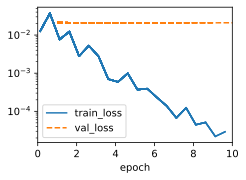

In [ ]:
train_scratch(0)

## 3.7.3.4. Với Weight Decay

L2 norm of w: 0.0016996401827782393


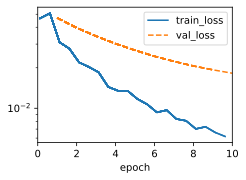

In [ ]:
train_scratch(3)

# 3.7.4. Triển khai ngắn gọn

Vì Weight Decay phổ biến trong tối ưu hóa mạng nơ ron nên frame học sâu làm cho nó trở nên thuận tiện, tích hợp Weight Decay vào chính thuật toán tối ưu hóa để dễ dàng sử dụng kết hợp với bất kỳ hàm mất mát nào. Hơn nữa, sự tích hợp này mang lại lợi ích về mặt tính toán, cho phép các thủ thuật triển khai để thêm phân rã trọng số cho thuật toán mà không cần thêm bất kỳ chi phí tính toán nào. Vì phần giảm dần trọng lượng của bản cập nhật chỉ phụ thuộc vào giá trị hiện tại của từng tham số nên trình tối ưu hóa vẫn phải chạm vào từng tham số một lần.

Trong đoạn mã sau, ta sẽ chỉ định trực tiếp siêu tham số `weigh_decay` khi khởi tạo trình tối ưu hóa. Theo mặc định, PyTorch phân ra đồng thời cả trọng số và độ lệch, nhưng ta có thể cấu hình trình tối ưu để xử lý các tham số khác nhau theo các chính sách khác nhau, ở đây ta chỉ đặt `weight_decay` ở trọng số nên bias sẽ không suy giảm

In [ ]:
class WeightDecay(d2l.LinearRegression):
  def __init__(self,wd,lr):
    super().__init__(lr)
    self.save_hyperparameters()
    #self.wd = wd
  def configure_optimizers(self):
    return torch.optim.SGD([
        {'params':self.net.weight, 'weight_decay': self.wd},
        {'params': self.net.bias}], lr = self.lr)

L2 norm of w: 0.015769585967063904
w: tensor([[ 0.0014,  0.0089,  0.0238,  0.0007, -0.0009,  0.0007,  0.0195, -0.0014,
          0.0091,  0.0034,  0.0090,  0.0074, -0.0148, -0.0166, -0.0050, -0.0013,
         -0.0071, -0.0082, -0.0077,  0.0047, -0.0284, -0.0085,  0.0146, -0.0067,
          0.0160, -0.0163,  0.0078, -0.0061,  0.0041,  0.0213,  0.0153,  0.0080,
          0.0078,  0.0035, -0.0150, -0.0087, -0.0108, -0.0189, -0.0016,  0.0211,
          0.0064, -0.0067,  0.0151, -0.0036,  0.0050,  0.0037,  0.0184, -0.0116,
          0.0209,  0.0100,  0.0208, -0.0154, -0.0134, -0.0054, -0.0194, -0.0105,
         -0.0103,  0.0114, -0.0105,  0.0146,  0.0133, -0.0093,  0.0198,  0.0062,
          0.0154,  0.0157, -0.0027,  0.0172,  0.0067,  0.0280, -0.0011, -0.0003,
         -0.0171,  0.0086,  0.0148,  0.0193, -0.0122, -0.0016,  0.0083, -0.0093,
          0.0113,  0.0071,  0.0139,  0.0031, -0.0003, -0.0003, -0.0062,  0.0143,
         -0.0037,  0.0191,  0.0136, -0.0068,  0.0081,  0.0001, -0.0057,

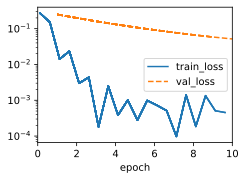

In [ ]:
model = WeightDecay(wd = 3, lr = 0.01)
model.board.yscale='log'
Trainer.fit(model, data)


In [ ]:
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))
print('w:', model.get_w_b()[0])

L2 norm of w: 0.015769585967063904
w: tensor([[ 0.0014,  0.0089,  0.0238,  0.0007, -0.0009,  0.0007,  0.0195, -0.0014,
          0.0091,  0.0034,  0.0090,  0.0074, -0.0148, -0.0166, -0.0050, -0.0013,
         -0.0071, -0.0082, -0.0077,  0.0047, -0.0284, -0.0085,  0.0146, -0.0067,
          0.0160, -0.0163,  0.0078, -0.0061,  0.0041,  0.0213,  0.0153,  0.0080,
          0.0078,  0.0035, -0.0150, -0.0087, -0.0108, -0.0189, -0.0016,  0.0211,
          0.0064, -0.0067,  0.0151, -0.0036,  0.0050,  0.0037,  0.0184, -0.0116,
          0.0209,  0.0100,  0.0208, -0.0154, -0.0134, -0.0054, -0.0194, -0.0105,
         -0.0103,  0.0114, -0.0105,  0.0146,  0.0133, -0.0093,  0.0198,  0.0062,
          0.0154,  0.0157, -0.0027,  0.0172,  0.0067,  0.0280, -0.0011, -0.0003,
         -0.0171,  0.0086,  0.0148,  0.0193, -0.0122, -0.0016,  0.0083, -0.0093,
          0.0113,  0.0071,  0.0139,  0.0031, -0.0003, -0.0003, -0.0062,  0.0143,
         -0.0037,  0.0191,  0.0136, -0.0068,  0.0081,  0.0001, -0.0057,